In [1]:
from __future__ import print_function
import numpy as np # Biblioteca de funciones matematicas de alto nivel
np.random.seed(1337)  # for reproducibility
import tensorflow as tf
import keras  
import pandas as pd

In [2]:
dataset = pd.read_csv('Train.csv', encoding = "ISO-8859-1") # lectura de datos
dataset1 = pd.read_csv('Test.csv', encoding = "ISO-8859-1") # lectura de datos


In [3]:
#Removed infinite and Nan values
dataset.replace([np.inf, -np.inf], -1, inplace=True) 
dataset.replace([np.nan, -np.nan], -1, inplace=True)

dataset1.replace([np.inf, -np.inf], -1, inplace=True) 
dataset1.replace([np.nan, -np.nan], -1, inplace=True)

## Remove biased Variables

In [4]:
#Eliminamos los datos mal introducidos
#Eliminamos los datos mal introducidos
dataset = dataset.drop(dataset[dataset['Dst Port']=='Dst Port'].index)
dataset1 = dataset1.drop(dataset1[dataset1['Dst Port']=='Dst Port'].index)

dataset = dataset[dataset['Flow IAT Min'] >= 0]
dataset1 = dataset1[dataset1['Flow IAT Min'] >= 0]
#Eliminamos las columnas innecesarias

dataset = dataset.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP','Unnamed: 0','Dst Port','Fwd Seg Size Min',
                       'Idle Min','Idle Mean','Idle Std','Idle Max'], axis=1)
dataset1 = dataset1.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP','Unnamed: 0','Dst Port','Fwd Seg Size Min',
                          'Idle Min','Idle Mean','Idle Std','Idle Max'], axis=1)
#Quitamos direcciones IP dest y src para no introducir sesgos, lo mismo con los puertos
#Quitar el puerto de destino es una modificación con respecto al trabajo original
#Eliminamos la columna de timestamp para no tener sesgo
dataset1 = dataset1.drop(['Timestamp'], axis=1)
dataset = dataset.drop(['Timestamp'], axis=1)
        

#Eliminamos la columna 
dataset

#Eliminamos la columna 

,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Active Mean,Active Std,Active Max,Active Min,Label
0,6,3025021,11,15,336.0,188.0,79.0,0.0,30.545455,38.624768,...,0,7,64240,181,6,0,0,0,0,FTP-BruteForce
1,6,468,2,1,79.0,0.0,79.0,0.0,39.500000,55.861436,...,0,0,502,0,0,0,0,0,0,FTP-BruteForce
2,6,3054906,13,15,338.0,188.0,79.0,0.0,26.000000,36.398260,...,0,6,64240,181,6,0,0,0,0,FTP-BruteForce
3,6,3046116,11,15,341.0,188.0,79.0,0.0,31.000000,38.348403,...,0,7,64240,181,6,0,0,0,0,FTP-BruteForce
4,6,3045413,13,15,351.0,188.0,86.0,0.0,27.000000,37.678464,...,0,6,64240,181,6,0,0,0,0,FTP-BruteForce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430151,17,9264,1,1,47.0,63.0,47.0,47.0,47.000000,0.000000,...,0,31,0,0,0,0,0,0,0,Benign
430152,0,91444297,51,0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,Benign
430153,17,101164777,6,6,1332.0,1032.0,222.0,222.0,222.000000,0.000000,...,0,86,0,0,5,0,0,0,0,Benign
430154,17,101009912,6,6,1332.0,1032.0,222.0,222.0,222.000000,0.000000,...,0,86,0,0,5,0,0,0,0,Benign


In [5]:
n=0
#Convert dataset columns into float type
for column in dataset:
    column
    if column != 'Label':
        dataset[column] = dataset[column].astype(float)
        
n=0
for column in dataset1:
    column
    if column != 'Label':
        dataset1[column] = dataset1[column].astype(float)


In [6]:
dataset.loc[(dataset.Label != 'Benign'),'Label']='Evil'
dataset1.loc[(dataset1.Label != 'Benign'),'Label']='Evil'
# Replace attack labels (e.g Golden eye,Hulk...) by just "evil"



#Rebalanced the dataset
dataset = dataset.drop(dataset[dataset['Label'] == 'Evil'].sample(frac=.5).index)
dataset1 = dataset1.drop(dataset1[dataset1['Label'] == 'Evil'].sample(frac=.5).index)



In [7]:
Labels = dataset['Label'].unique()
Y_train = dataset["Label"]
Y_test =  dataset1["Label"]
#Fill Y values

## Removed Variables without variance

In [8]:
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt

datasetaux=dataset1
datasetaux["newLabel"]=dataset1['Flow IAT Min']*0

X_train=dataset.iloc[:, 0:72] #Luego obtenemos las características del flujo
X_test=dataset1.iloc[:, 0:72]

aux=X_train.var()

#Remove variables with zero variance
for col in X_train.columns:
    if X_train[col].var() == 0:
        print(col)
        X_train=X_train.drop(col, axis =1)
        X_test=X_test.drop(col, axis =1)
        datasetaux=datasetaux.drop(col, axis =1)
       
        #Aqui iria un drop
#0-Bening
#1-DoS attacks-GoldenEye
#2-DoS attacks-Hulk
#3-'DoS attacks-SlowHTTPTest
#4-'DoS attacks-Slowloris
#5'FTP-BruteForce,
#6'SSH-Bruteforce

        
#datasetaux['newLabel'][datasetaux['Label'] == 'Benign'] = 0
#datasetaux['newLabel'][datasetaux['Label'] == 'DoS attacks-GoldenEye'] = 1
#datasetaux['newLabel'][datasetaux['Label'] == 'DoS attacks-Hulk'] = 2
#datasetaux['newLabel'][datasetaux['Label'] == 'DoS attacks-SlowHTTPTest'] = 3
#datasetaux['newLabel'][datasetaux['Label'] == 'DoS attacks-Slowloris'] = 4
#datasetaux['newLabel'][datasetaux['Label'] == 'FTP-BruteForce'] = 5
#datasetaux['newLabel'][datasetaux['Label'] == 'SSH-Bruteforce'] = 6

#datasetaux=datasetaux.drop(['Label'],axis=1)

#datasetaux.to_csv("TestV3.dat", sep=',', encoding='utf-8')
       
#Get the used features
features = list(X_train.columns)

Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
URG Flag Cnt
CWE Flag Count
ECE Flag Cnt
Fwd Byts/b Avg
Fwd Pkts/b Avg
Fwd Blk Rate Avg
Bwd Byts/b Avg
Subflow Bwd Pkts
Active Mean
Active Std
Active Max
Active Min


In [9]:
from sklearn.preprocessing import LabelEncoder
 
lb_make = LabelEncoder()
Y_train = lb_make.fit_transform(Y_train) #para pasar a numeros
#Convert Train labels into numbers Benign->0 Evil->1

Labels = lb_make.inverse_transform(Y_train)
Labels = list(lb_make.classes_)
Y_train

array([1, 1, 1, ..., 0, 0, 0])

In [10]:
from numpy import savetxt
lb_make = LabelEncoder()
Y_test = lb_make.fit_transform(Y_test)
 
#Convert Test labels into numbers Benign->0 Evil->1 
Labels1 = lb_make.inverse_transform(Y_test)
Labels1 = list(lb_make.classes_)
Y_test

array([1, 1, 1, ..., 0, 0, 0])

## Dataset values

In [11]:
dataset["Label"].value_counts()

Evil      154193
Benign    120096
Name: Label, dtype: int64

In [12]:
dataset1["Label"].value_counts()

Evil      34793
Benign    32228
Name: Label, dtype: int64

## Multilayer perceptron 

### Libraries

In [13]:

import shap #Also import Shap library

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline



### Neuronal Network training

In [14]:
X_trainArr=X_train.to_numpy()
#Convert X_train to numpy array due to MLP library compatibility

import time
inicio=time.time() #Get initial time to measure Neural Network training

inicio = time.time()
model = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(16,12),activation='relu', max_iter=50,random_state=0)
)

model.fit(X_trainArr,Y_train)

fin = time.time() #Get final time of the MPL training
tiempo_neurona = fin-inicio
print(tiempo_neurona)

273.4215478897095


Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.


## Model evaluation 

### Evaluation over Training data

In [15]:
# evaluate the MLP over training data

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
X_testArr = X_test.to_numpy()
Y_pred=model.predict(X_trainArr)
LabelsArr = np.array(Labels)
Labels
LabelsArr
y_test1 = []
for i in range(0, Y_train.size):
        if Y_train[i] == 1:
            y_test1.append("Evil")
        else:
            y_test1.append("Benign")
y_pred1 = []
for i in range(0, Y_pred.size):
        if Y_pred[i] == 1:
            y_pred1.append("Evil")
        else:
            y_pred1.append("Benign")


In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test1, y_pred1, digits=8, zero_division= "warn"))

              precision    recall  f1-score   support

      Benign  0.99215407 0.95186351 0.97159127    120096
        Evil  0.96365751 0.99413722 0.97866010    154193

    accuracy                      0.97562790    274289
   macro avg  0.97790579 0.97300036 0.97512569    274289
weighted avg  0.97613458 0.97562790 0.97556505    274289



<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

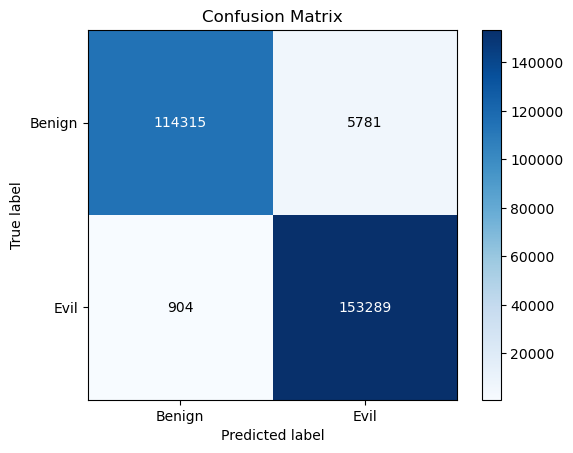

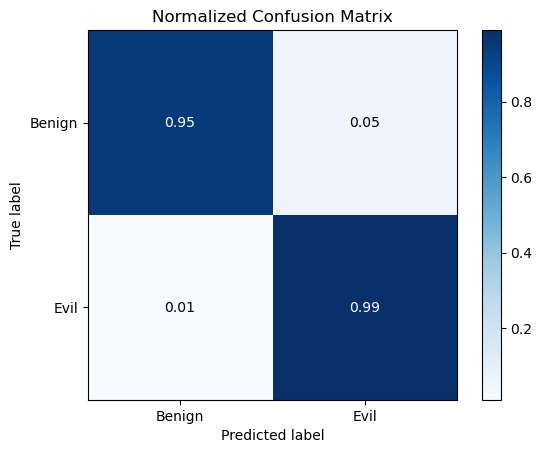

In [17]:
import scikitplot as skplt
#Show confusión matrix 
skplt.metrics.plot_confusion_matrix(y_test1, y_pred1)
skplt.metrics.plot_confusion_matrix(y_test1, y_pred1, normalize= True)

### Evaluation over test data

In [18]:
# evaluate the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
X_testArr = X_test.to_numpy()
Y_pred=model.predict(X_testArr)
LabelsArr = np.array(Labels)
Labels
LabelsArr
y_test1 = []
for i in range(0, Y_test.size):
        if Y_test[i] == 1:
            y_test1.append("Evil")
        else:
            y_test1.append("Benign")
y_pred1 = []
for i in range(0, Y_pred.size):
        if Y_pred[i] == 1:
            y_pred1.append("Evil")
        else:
            y_pred1.append("Benign")
            



In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test1, y_pred1, digits=8, zero_division= "warn"))



              precision    recall  f1-score   support

      Benign  0.98771555 0.94554425 0.96616994     32228
        Evil  0.95147778 0.98910700 0.96992757     34793

    accuracy                      0.96815923     67021
   macro avg  0.96959667 0.96732563 0.96804875     67021
weighted avg  0.96890323 0.96815923 0.96812066     67021



<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

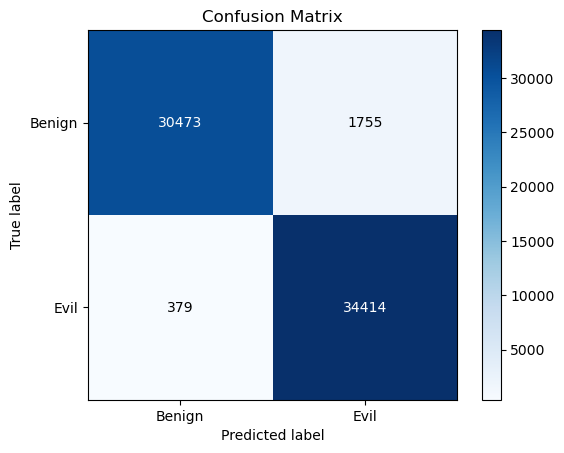

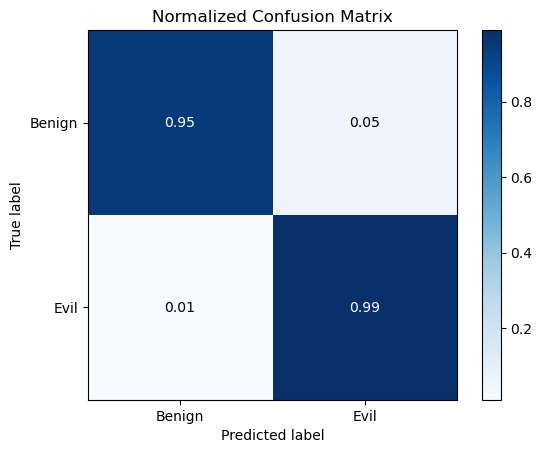

In [20]:

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test1, y_pred1)
skplt.metrics.plot_confusion_matrix(y_test1, y_pred1, normalize= True)

## XAI technique: SHAP

In [21]:
size=200 #Data sample to examinate. More data implies much more time to process
data=shap.sample(X_trainArr, size)
explainer = shap.KernelExplainer(model.predict,data)
expected_value = explainer.expected_value
data1=shap.sample(X_testArr, size)
shap_values = explainer.shap_values(data1,nsamples=size)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [22]:
#np.savetxt('ataqueV2.1.txt',shap_values)




### SHAP Graphic 1

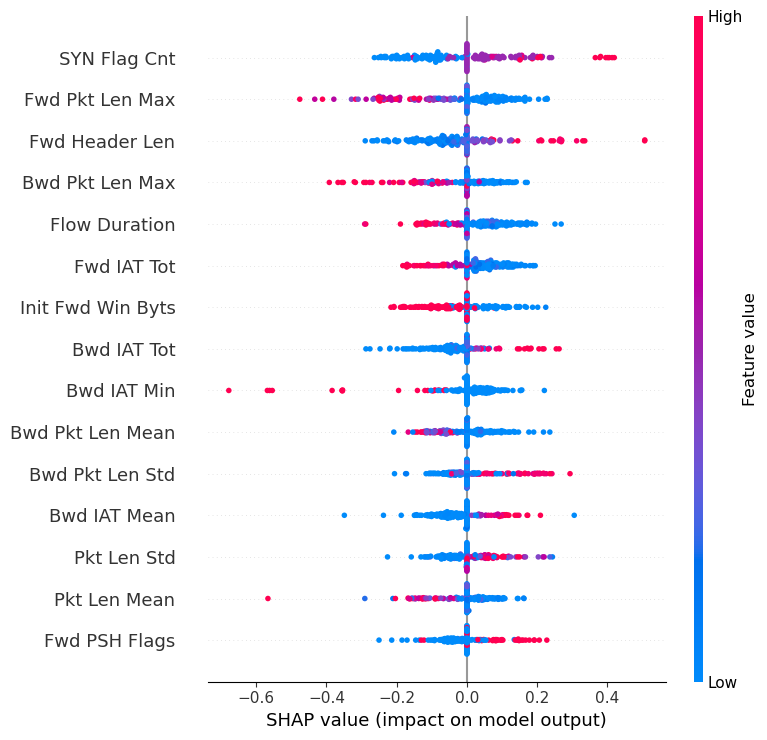

In [23]:
shap.summary_plot(shap_values,data1,feature_names=features,max_display=15)
#The color of the point deteminates the feature value. And the position determinates the impact of that feature in the model. 
#In this case, A low value in Fwd Header Len implies that the neural network is more likely to decide that this flow is benign.
#But keep in mind that a neural network decition is based on the combination of many features.

#### Results' verification

count    2.742890e+05
mean     5.880981e+02
std      6.884858e+03
min      0.000000e+00
25%      6.400000e+01
50%      1.720000e+02
75%      3.280000e+02
max      1.510520e+06
Name: Fwd Header Len, dtype: float64
count    1.200960e+05
mean     8.429220e+02
std      1.037687e+04
min      0.000000e+00
25%      4.000000e+01
50%      9.200000e+01
75%      2.720000e+02
max      1.510520e+06
Name: Fwd Header Len, dtype: float64


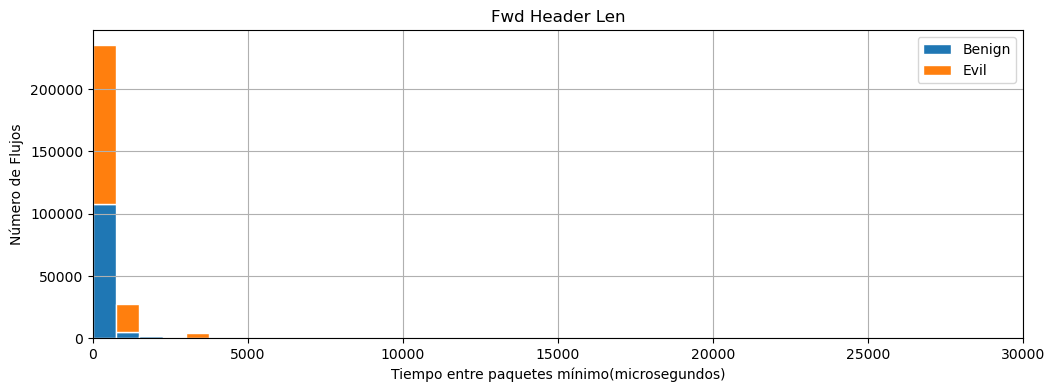

In [24]:
#With the following code it is possible to representate a dataset feature histogram. You only have to change "caracteris", bin and lim
caracteris= 'Fwd Header Len'

lim=30000
pruebadf=dataset.loc[dataset[caracteris] < lim]
print(dataset[caracteris].describe())
bin = 40

plt.rcParams["figure.figsize"] = (12,4)

n, bins, patches = plt.hist(
    [pruebadf.loc[pruebadf['Label'] == 'Benign',caracteris],
     pruebadf.loc[pruebadf['Label'] == 'Evil',caracteris]],
    stacked=True,
    label=['Benign','Evil'],
    edgecolor='white',
    bins = bin,
    )


print(dataset.loc[dataset['Label'] == 'Benign',caracteris].describe())


plt.legend()
plt.grid()
plt.title(caracteris)
plt.ylabel("Número de Flujos")
plt.xlabel("Tiempo entre paquetes mínimo(microsegundos)")
plt.xlim([0,lim])
plt.savefig("Número de banderas.pdf")

(0.0, 400.0)

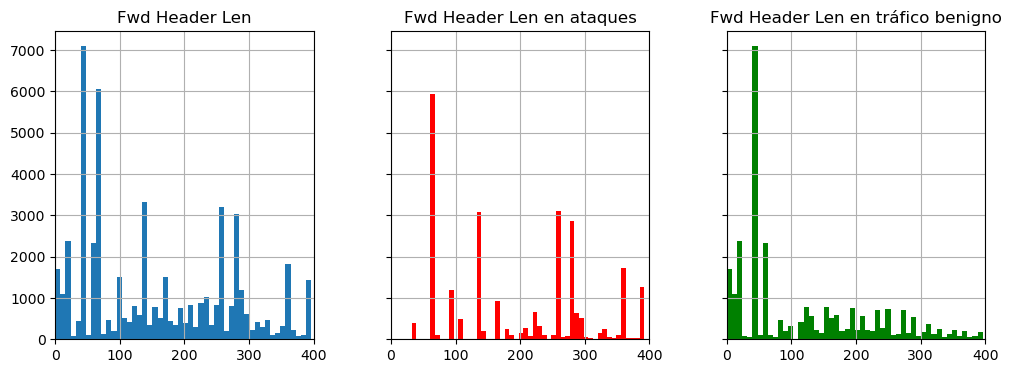

In [25]:
#Histograma del FWdSigSezSize

caracteris= 'Fwd Header Len'
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True,figsize=(12,4))
lim=400

pruebadf=dataset1.loc[dataset1[caracteris] < lim]
evildf=pruebadf.loc[pruebadf['Label'] == "Evil"]
Benigndf=pruebadf.loc[pruebadf['Label'] == "Benign"]

bin = 50


pruebadf.hist(column=caracteris, ax = ax[0],bins = bin)
evildf.hist(column=caracteris, ax = ax[1],color="red",bins = bin)
Benigndf.hist(column=caracteris, ax = ax[2],color="green",bins = bin)


ax[0].set_title(caracteris )
ax[1].set_title( caracteris+" en ataques")
ax[2].set_title(caracteris+ " en tráfico benigno")

ax[0].set_xlim([0, lim])

ax[1].set_xlim([0, lim])

ax[2].set_xlim([0, lim])

### SHAP graphic 2
Features contribution to neural network output

In [26]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,data1,feature_names=features, out_names=Labels)



In [27]:
y_preddata=model.predict(data1)


### SHAP graphic 3
Contribution of a single flow

In [28]:
num=104;

shap.force_plot(explainer.expected_value, shap_values[num,:]  ,data1[num,:],feature_names=features, figsize=[15,28])
#1 maligno #0 benigno

### SHAP graphic 4
SHAP values of a single flow represented in waterfall mode. 1-> Flow is evil; 0-> FLow is benign

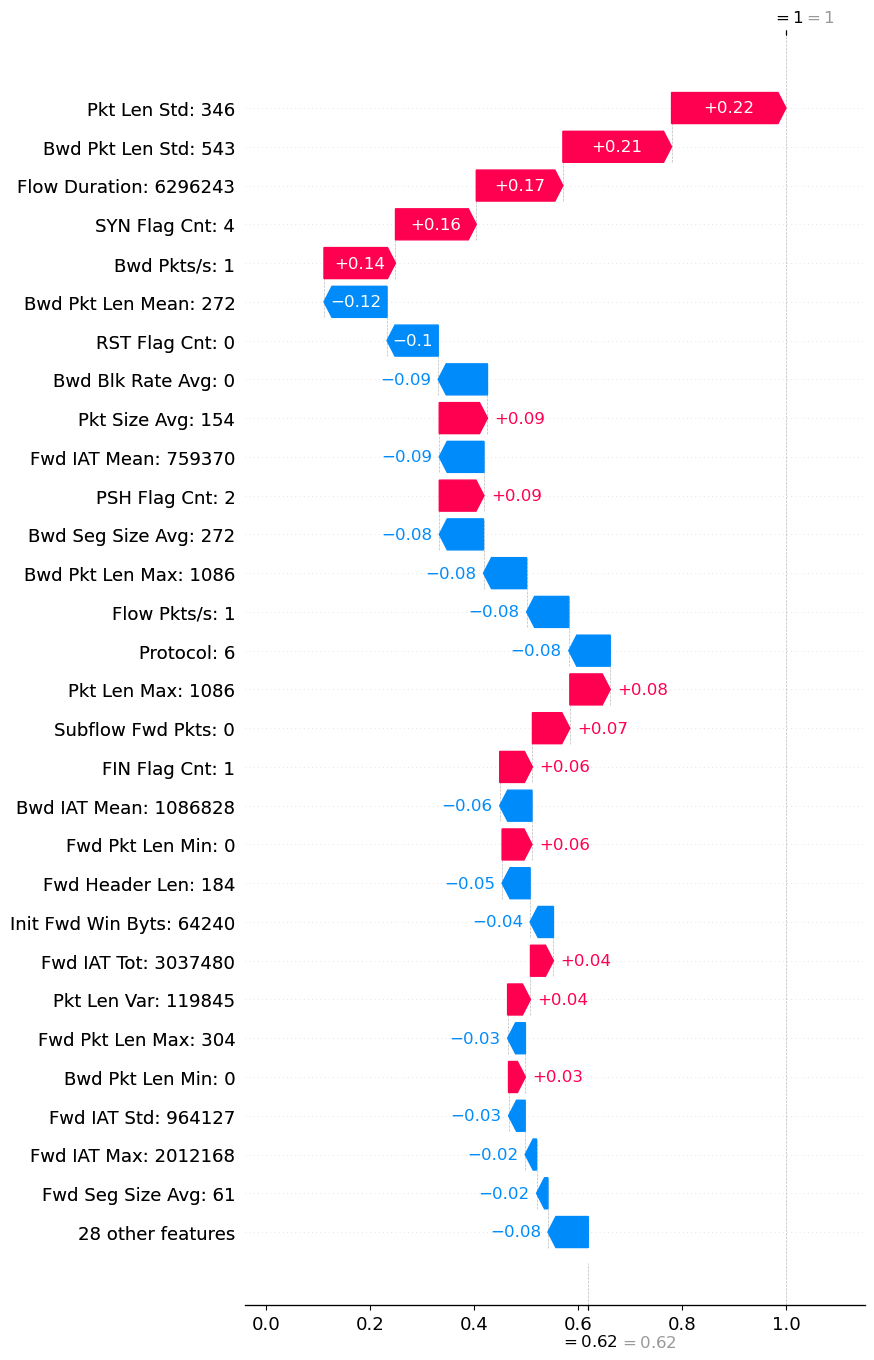

In [29]:
#SHAP values of a single flow represented in waterfall mode. 1-> Flow is evil; 0-> FLow is benign
feature = [a + ": " + str(int(b)) for a,b in zip(features, data1[num].round(0))]

shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[num],feature_names=feature, max_display=30)


### SHAP Graphic 5
In this case the graphic shows the mean SHAP values of every flow that the Neural network identifies as a Benign/Evil.
#What are the common features of a benign/evil flow?.

Benign


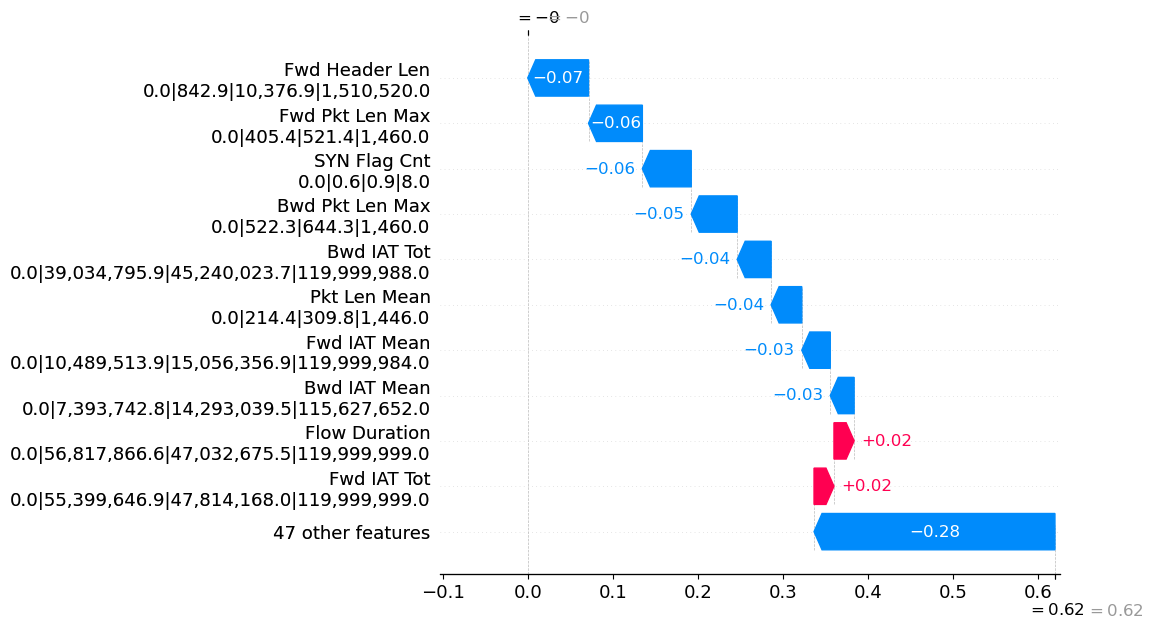

In [30]:
 

#0-Bening
#1-DoS attacks-GoldenEye
#2-DoS attacks-Hulk
#3-'DoS attacks-SlowHTTPTest
#4-'DoS attacks-Slowloris
#5'FTP-BruteForce,
#6'SSH-Bruteforce
nuevo_shap=shap_values[0]*0
nuevo_data = data1[0]*0
nuevo_min=data1[0]
nuevo_max=nuevo_data
nuevo_std=nuevo_data

acum=0
ata=0
margen=0.2

if ata==1:
    clase ='Evil'
else:
    clase ='Benign'

for i in range(size):
    suma=shap_values[i].sum()+explainer.expected_value
    if  (suma > (ata-abs(margen)))  and (suma < (ata+abs(margen))):
        nuevo_shap=nuevo_shap+shap_values[i]
        nuevo_data=nuevo_data+data1[i]
        nuevo_min =np.minimum(nuevo_min,data1[i])
        nuevo_max =np.maximum(nuevo_max,data1[i])
        acum=acum+1
nuevo_shap=nuevo_shap/acum
nuevo_data=nuevo_data/acum
#Calculo del STD
for i in range(size):
    suma=shap_values[i].sum()+explainer.expected_value
    if  (suma > (ata-abs(margen)))  and (suma < (ata+abs(margen))):
        
        nuevo_std= nuevo_std+((data1[i]-nuevo_data)**2)
       
nuevo_std = (nuevo_std/acum)**0.5


#print('{0:,}'.format(int(nuevo_max[1])))
#"|" + '{0:,}'.format(int(e)) 
feature = [a + "\n" + '{0:,}'.format(b) +"|" +'{0:,}'.format(c) +"|" +'{0:,}'.format(d)+"|" +'{0:,}'.format(e)
           for a,b,c,d,e in zip(features,dataset.loc[dataset['Label'] == clase,features].min().round(1),
                                dataset.loc[dataset['Label'] == clase,features].mean().round(1),
                                dataset.loc[dataset['Label'] == clase,features].std().round(1),
                                dataset.loc[dataset['Label'] == clase,features].max().round(1),
                               )]
print(Labels[ata])
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, nuevo_shap,feature_names=feature, max_display=11)

#shap.summary_plot(shap_values, data1, plot_type="bar", class_names= Labels1, feature_names = features)
#Revisar que significa el explainer expecteed value

## Random Forest

In [31]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn import tree


### Random Forest Train

In [32]:
#clf = tree.DecisionTreeClassifier(random_state=0)
import time

inicio = time.time()


n_estimators=200
clf = RandomForestClassifier(random_state=0,n_estimators=n_estimators,max_depth=5)
#    max_features
clf = clf.fit(X_trainArr,Y_train)
#Con 3    0.92
#COn 04   0.96097880

fin = time.time()
tiempo_random = fin-inicio
print(tiempo_random)

192.98279809951782


### Random Forest train evaluation

In [33]:
Y_predtree=clf.predict(X_trainArr)
LabelsArr = np.array(Labels)
y_testree1 = []
for i in range(0, Y_train.size):
        if Y_train[i] == 1:
            y_testree1.append("Evil")
        else:
            y_testree1.append("Benign")
y_predtree1 = []
for i in range(0, Y_predtree.size):
        if Y_predtree[i] == 1:
            y_predtree1.append("Evil")
        else:
            y_predtree1.append("Benign")

In [34]:
print(classification_report(y_testree1, y_predtree1, digits=8, zero_division= "warn"))
accuracy_modelo=accuracy_score(Y_train, Y_predtree)

              precision    recall  f1-score   support

      Benign  0.99817452 0.98345490 0.99076004    120096
        Evil  0.98725988 0.99859916 0.99289715    154193

    accuracy                      0.99196833    274289
   macro avg  0.99271720 0.99102703 0.99182859    274289
weighted avg  0.99203880 0.99196833 0.99196143    274289



<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

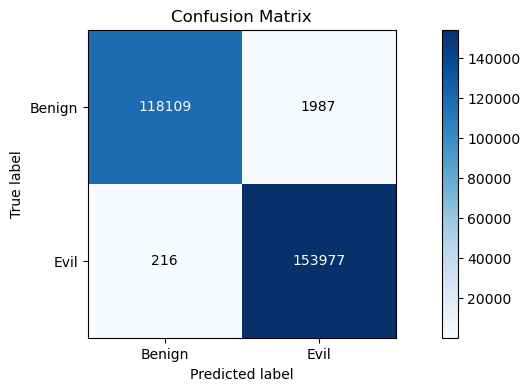

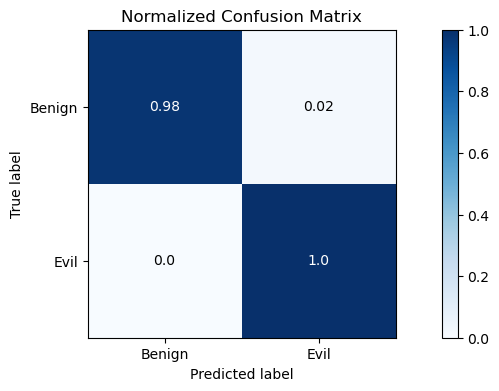

In [35]:
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1)
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1, normalize= True)

### Random Forest Test evaluation

In [36]:
Y_predtree=clf.predict(X_testArr)
LabelsArr = np.array(Labels)
y_testree1 = []
for i in range(0, Y_test.size):
        if Y_test[i] == 1:
            y_testree1.append("Evil")
        else:
            y_testree1.append("Benign")
y_predtree1 = []
for i in range(0, Y_predtree.size):
        if Y_predtree[i] == 1:
            y_predtree1.append("Evil")
        else:
            y_predtree1.append("Benign")

In [37]:
print(classification_report(y_testree1, y_predtree1, digits=8, zero_division= "warn"))


              precision    recall  f1-score   support

      Benign  0.99440829 0.97669728 0.98547322     32228
        Evil  0.97876552 0.99491277 0.98677309     34793

    accuracy                      0.98615359     67021
   macro avg  0.98658690 0.98580503 0.98612315     67021
weighted avg  0.98628757 0.98615359 0.98614803     67021



<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

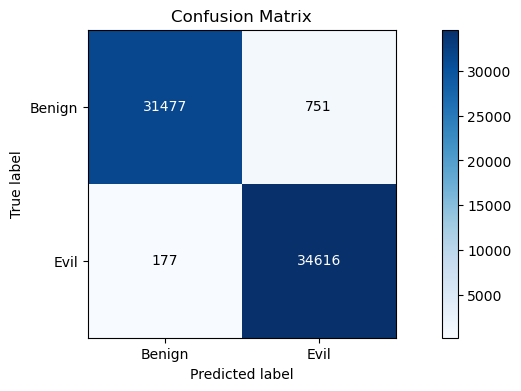

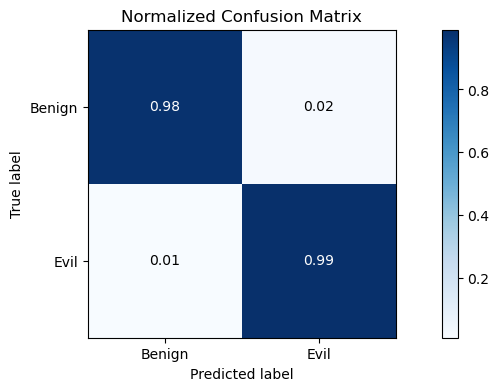

In [38]:
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1)
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1, normalize= True)

## Decision Tree

In [45]:
#plt.plot_tree(clf, feature_names=features,  class_names=Labels,filled=True)

#Evaluate every Random Forest' decision tree and choose the fittest.
from matplotlib.backends.backend_pdf import PdfPages
accuracy_ant=0
accuracy_med=0
accuracy_pon=0
accuracy_pon_ant=0
best=0
dist_ant=1000
from tqdm import tqdm
#tqdm(range(n_estimators))
import time
inicio=time.time()

for i in range(n_estimators):
    aux_clf = clf.estimators_[i]
    y_pred_train=aux_clf.predict(X_trainArr)
    y_pred_test=aux_clf.predict(X_testArr)
    accuracy=accuracy_score(Y_test, y_pred_test)
    
    accuracy_train=accuracy_score(Y_train, y_pred_train)
    accuracy_pon = accuracy_train*accuracy
    
    #dist=abs(accuracy_modelo-accuracy)
    
    if accuracy_pon > accuracy_pon_ant:
        pon=i
        accuracy_pon_ant=accuracy_pon
        accuracy_pon_train = accuracy_train
        accuracy_pon_test = accuracy

fin = time.time()
tiempo_extra = fin-inicio
print(tiempo_extra)

    #if accuracy > accuracy_ant:
     #   best = i
      #  accuracy_ant=accuracy
        
    #if dist < dist_ant:
     #   med = i
      #  accuracy_med=accuracy
       # dist_ant = dist


#fig = plt.figure(figsize=(45,10))
#_ = tree.plot_tree(clf.estimators_[best], feature_names=features,  class_names=Labels,filled=True)

#fig2 = plt.figure(figsize=(45,15))
#_ = tree.plot_tree(clf.estimators_[med], feature_names=features,  class_names=Labels,filled=True)



29.1685733795166


In [47]:
#Represent the decision tree
import graphviz
# DOT data
dot_data = tree.export_graphviz(clf.estimators_[pon], out_file=None, feature_names=features,  
                                class_names=Labels,
                                filled=True)
#graph = graphviz.Source(dot_data, format="png") 
#graph
#graph.render("decision_tree_graphivz")

### Evaluation of the Decision tree

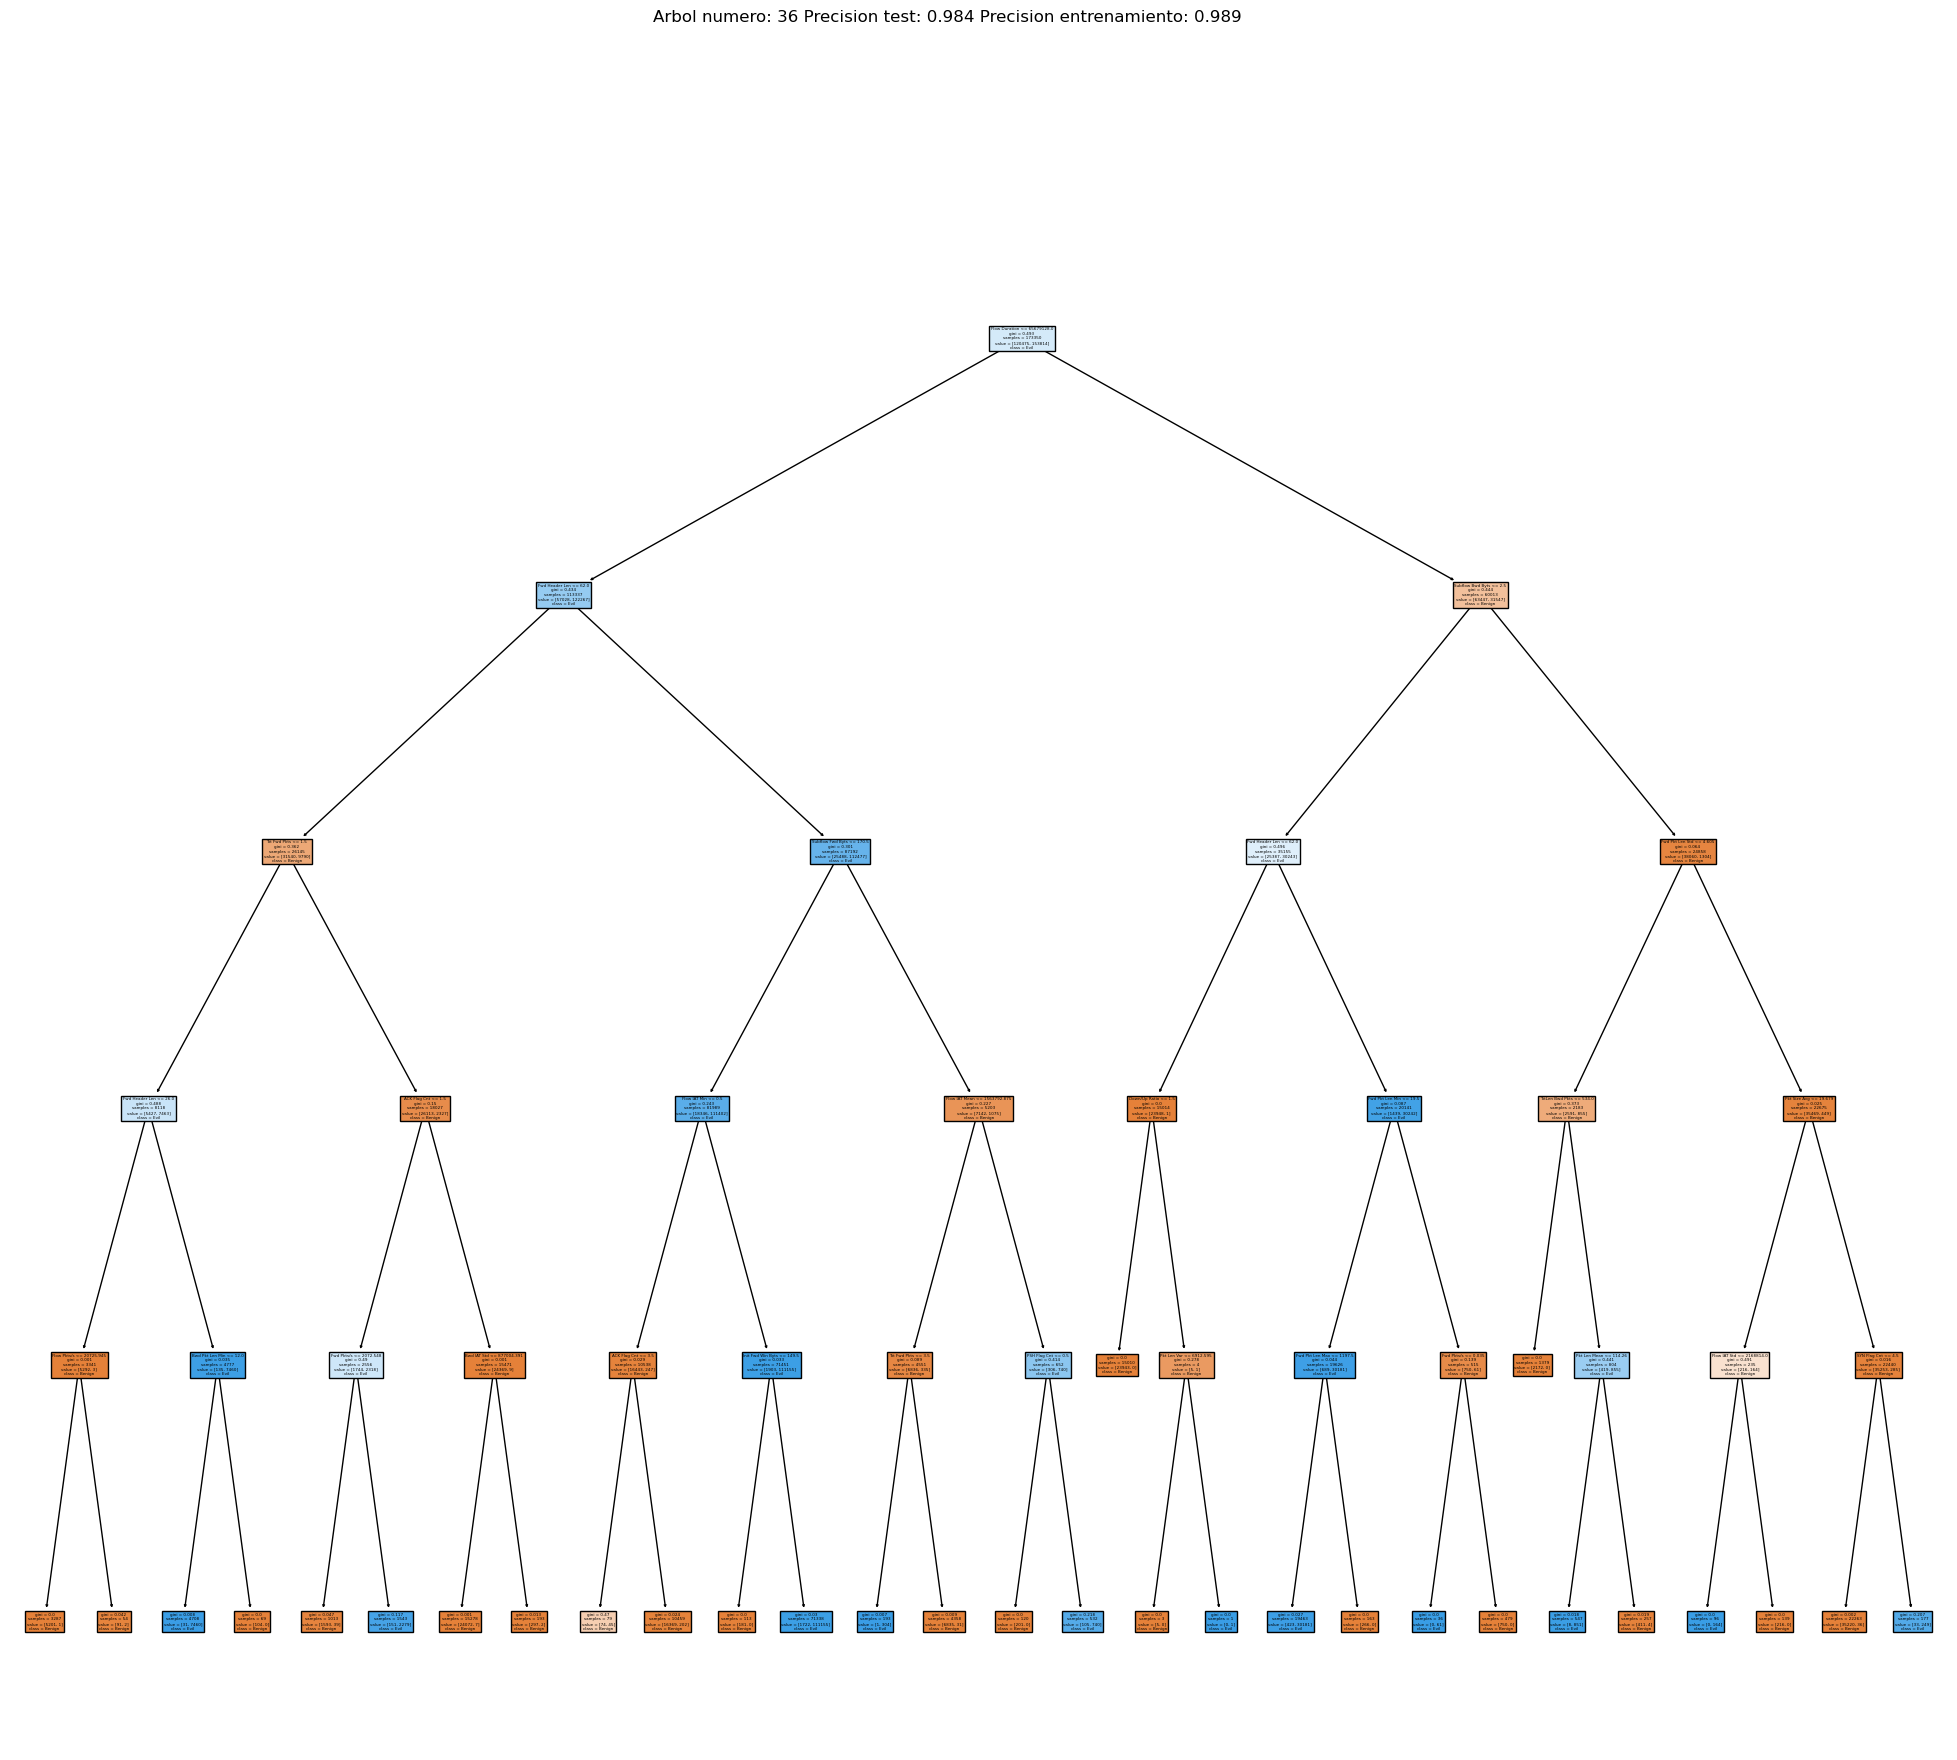

In [49]:
fig3 = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf.estimators_[pon], feature_names=features,  class_names=Labels,filled=True)

#fig.suptitle('Arbol numero: '+str(best)+' Precision: '+ str(round(accuracy_ant,3)))
#fig.savefig("decistion_tree.pdf")

#fig2.suptitle('Arbol numero: '+str(med)+' Precision: '+ str(round(accuracy_med,3)))
#fig2.savefig("decistion_tree_mean.pdf")

fig3.suptitle('Arbol numero: '+str(pon)+' Precision test: '+ str(round(accuracy_pon_test,3)) +' Precision entrenamiento: '+ str(round(accuracy_pon_train,3)))
fig3.savefig("decistion_tree_pon4Ramas.png")

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

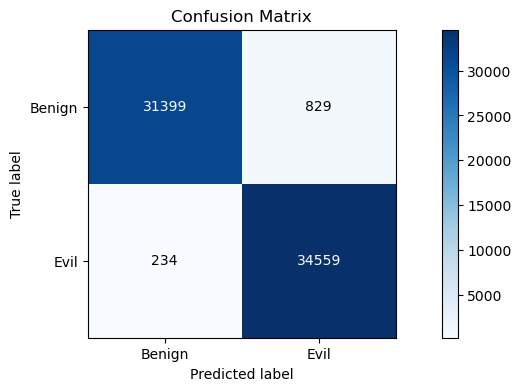

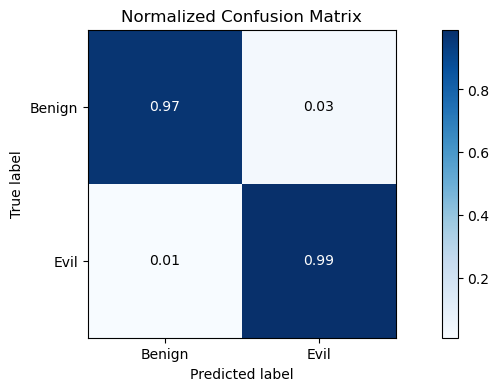

In [50]:
arbol_pon=clf.estimators_[pon]
Y_predtree=arbol_pon.predict(X_testArr)
LabelsArr = np.array(Labels)
y_testree1 = []
for i in range(0, Y_test.size):
        if Y_test[i] == 1:
            y_testree1.append("Evil")
        else:
            y_testree1.append("Benign")
y_predtree1 = []
for i in range(0, Y_predtree.size):
        if Y_predtree[i] == 1:
            y_predtree1.append("Evil")
        else:
            y_predtree1.append("Benign")
            
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1)
skplt.metrics.plot_confusion_matrix(y_testree1, y_predtree1, normalize= True)


## Get Decision Tree times

In [43]:
dataset0 = pd.read_csv('Train.csv', encoding = "ISO-8859-1") # lectura de datos
dataset01 = pd.read_csv('Test.csv', encoding = "ISO-8859-1") # lectura de datos

dataset0.replace([np.inf, -np.inf], -1, inplace=True) 
dataset0.replace([np.nan, -np.nan], -1, inplace=True)

dataset01.replace([np.inf, -np.inf], -1, inplace=True) 
dataset01.replace([np.nan, -np.nan], -1, inplace=True)

dataset0 = dataset0.drop(dataset0[dataset0['Dst Port']=='Dst Port'].index)
dataset01 = dataset01.drop(dataset01[dataset01['Dst Port']=='Dst Port'].index)

#Eliminamos las columnas innecesarias

dataset0 = dataset0.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP','Unnamed: 0','Dst Port','Fwd Seg Size Min',
                       'Idle Min','Idle Mean','Idle Std','Idle Max'], axis=1)
dataset01 = dataset01.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP','Unnamed: 0','Dst Port','Fwd Seg Size Min',
                          'Idle Min','Idle Mean','Idle Std','Idle Max'], axis=1)
#Quitamos direcciones IP dest y src para no introducir sesgos, lo mismo con los puertos
#Quitar el puerto de destino es una modificación con respecto al trabajo original
#Eliminamos la columna de timestamp para no tener sesgo
dataset01 = dataset01.drop(['Timestamp'], axis=1)
dataset0 = dataset0.drop(['Timestamp'], axis=1)

dataset0.loc[(dataset0.Label != 'Benign'),'Label']='Evil'
dataset01.loc[(dataset01.Label != 'Benign'),'Label']='Evil'

X_train0=dataset0.iloc[:, 0:72] #Luego obtenemos las características del flujo
X_test0=dataset01.iloc[:, 0:72]



for col in X_train0.columns:
    if X_train0[col].var() == 0:
        print(col)
        X_train0=X_train0.drop(col, axis =1)
        X_test0=X_test0.drop(col, axis =1)
        
X_trainArr0=X_train0.to_numpy()
X_testArr0=X_test0.to_numpy()

X_tiempo=np.concatenate((X_trainArr0, X_testArr0), axis=0)

print(X_tiempo.shape)
#model
#clf
#arbol_pon

Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
URG Flag Cnt
CWE Flag Count
ECE Flag Cnt
Fwd Byts/b Avg
Fwd Pkts/b Avg
Fwd Blk Rate Avg
Bwd Byts/b Avg
Subflow Bwd Pkts
Active Mean
Active Std
Active Max
Active Min
(532148, 57)


In [44]:
#    max_features
import time
inicio = time.time()
Y_predtree=arbol_pon.predict(X_tiempo)
fin = time.time()

print(fin-inicio)
print(tiempo_neurona,tiempo_random,tiempo_extra) 

0.2739708423614502
273.4215478897095 192.98279809951782 60.381969928741455
